In [1]:
# package importing

import cupy as cp
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from numba import jit, prange

# for getContour function 
import cv2

## Scaling Parameters

In [2]:
width, height, distance, xShift, yShift = np.float64(0), np.float64(0), np.float64(0), np.float64(0), np.float64(0)

def setScale(*args):
    # physical size in um: width, height, distance (positive if sample at +z)
    global width, height, distance, xShift, yShift

    if len(args)==3:
        width, height, distance = np.float64(args[0]), np.float64(args[1]), np.float64(args[2])
    elif len(args)==5:
        width, height, distance, xShift, yShift = np.float64(args[0]), np.float64(args[1]), np.float64(args[2]), np.float64(args[3]), np.float64(args[4])
    else:
        width = np.float64(input('physical size: width:\t'))
        height = np.float64(input('physical size: height:\t'))
        distance = np.float64(input('physical size: distance:\t'))
        xShift = np.float64(input('physical size: xShift:\t'))
        yShift = np.float64(input('physical size: yShift:\t'))
    
    return None

In [3]:
setScale(280,175,12.,0.,0.)

## Loading B Field Data

In [4]:
bExp = cp.zeros(shape=(1,1,1),dtype=cp.float64)
bPixelX, bPixelY = 1,1

def loadB():
    # loading magnetic field data (in .npy format)
    global bExp, bPixelX, bPixelY

    root = tk.Tk()
    bX = np.load(filedialog.askopenfilename(title="Select Bx Data (in .npy format)"))
    root.withdraw()
    bPixelX, bPixelY = bX.shape

    root = tk.Tk()
    root.withdraw()
    bY = np.load(filedialog.askopenfilename(title="Select By Data (in .npy format)"))

    root = tk.Tk()
    root.withdraw()
    bZ = np.load(filedialog.askopenfilename(title="Select Bz Data (in .npy format)"))

    bExp = cp.asarray(np.concatenate((bX[:,:,np.newaxis],bY[:,:,np.newaxis],bZ[:,:,np.newaxis]),axis=2))

    return None

In [5]:
loadB()

## Selecting B Region of Interest

In [5]:
def bShow(bMap):

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    bRMSFull = np.sqrt(cp.sum(bMap**2)/bPixelX/bPixelY/3)
    HB = min(2*bRMSFull, cp.max(bMap))
    LB = max(-2*bRMSFull,cp.min(bMap))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Bx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('By')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(bMap[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Bz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bPixelX)
    yTicks, yTickLabels = makeYTicks(bPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    return None

In [6]:
bStartX, bStartY, bEndX, bEndY, bCropX, bCropY = 0,0,bPixelX,bPixelY,bPixelX,bPixelY
bRMS = np.sqrt(cp.sum(bExp**2)/bPixelX/bPixelY/3)
bCropped = cp.copy(bExp)

def bCropping(ifBalanced=False):
    # selecting region of interest
    global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped

    bShow(bExp)
    plt.savefig('bShow.png', format='png')

    root = tk.Tk()
    root.title("Selecting B Region")

    canvas = tk.Canvas(root)
    image = tk.PhotoImage(master=canvas, file='bShow.png')
    image_label = tk.Label(root, image=image)
    image_label.image = image
    image_label.pack()

    label_start_x = tk.Label(root, text="StartX=")
    label_start_x.pack()

    entry_start_x = tk.Entry(root)
    entry_start_x.pack()

    label_start_y = tk.Label(root, text="StartY=")
    label_start_y.pack()

    entry_start_y = tk.Entry(root)
    entry_start_y.pack()

    label_end_x = tk.Label(root, text="EndX=")
    label_end_x.pack()

    entry_end_x = tk.Entry(root)
    entry_end_x.pack()

    label_end_y = tk.Label(root, text="EndY=")
    label_end_y.pack()

    entry_end_y = tk.Entry(root)
    entry_end_y.pack()

    def on_enter_button_clicked():
        # Get values from entry widgets, remain unchanged if empty
        global bStartX, bStartY, bEndX, bEndY, bCropX, bCropY, bRMS, bCropped
        bStartX = int(entry_start_x.get()) if entry_start_x.get() != '' else bStartX
        bStartY = int(entry_start_y.get()) if entry_start_y.get() != '' else bStartY
        bEndX = int(entry_end_x.get()) if entry_end_x.get() != '' else bEndX
        bEndY = int(entry_end_y.get()) if entry_end_y.get() != '' else bEndY
        bCropX = bEndX - bStartX
        bCropY = bEndY - bStartY
        bCropped = bExp[bStartX:bEndX,bStartY:bEndY,:]
        if ifBalanced:
            bAVG = cp.sum(bCropped) / bCropX / bCropY
            bCropped -= bAVG
        bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
        
        root.destroy()
        root.quit()

        print(f"StartX={bStartX}, StartY={bStartY}, EndX={bEndX}, EndY={bEndY}")
        return None
    
    def on_cancel_button_clicked():
        root.destroy()
        root.quit()
        return None

    button_enter = tk.Button(root, text="Enter", command=on_enter_button_clicked)
    button_enter.pack()
    button_cancel = tk.Button(root, text="Cancel", command=on_cancel_button_clicked)
    button_cancel.pack()

    root.mainloop()

    os.remove('bShow.png')
    
    return None

StartX=130, StartY=20, EndX=420, EndY=290


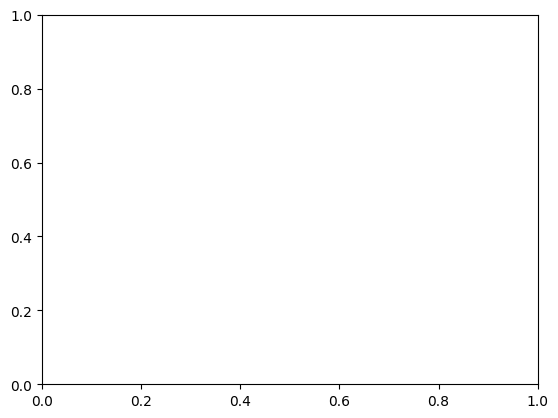

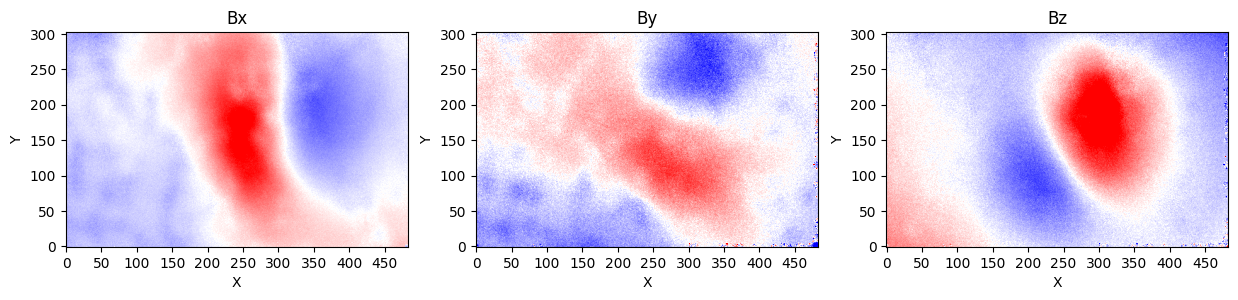

In [8]:
bCropping()

## Selecting Magnetization Region

In [12]:
mPixelX, mPixelY, NofP, listX, listY, mRes = 1,1,1,np.array([0]),np.array([0]),cp.zeros(shape=(1,3),dtype=cp.float64)
mAVG = 1

def spinAllocate(magFactor=1):
    global mPixelX, mPixelY, NofP, listX, listY, mRes, mAVG

    root = tk.Tk()
    image_path = filedialog.askopenfilename(title="Select camera image")
    root.withdraw()
    img_ = cv2.imread(image_path)  # The image should be larger than img_w * img_h
    mPixelY, mPixelX = img_.shape[0:2] # Original image height and width
    cv2.destroyAllWindows()
    
    def main():
        global all_polygons, current_polygon, img, img_copy
        all_polygons = []
        current_polygon = []
        def draw_polygons(event, x, y, flags, param):
            global all_polygons, current_polygon, img, img_copy
            if event == cv2.EVENT_LBUTTONDOWN:  # 左键点击
                current_polygon.append((x, y))
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
                if len(current_polygon) > 1:
                    cv2.line(img, current_polygon[-2], current_polygon[-1], (255, 0, 0), 2)
                cv2.imshow('image', img)
            elif event == cv2.EVENT_RBUTTONDOWN:  # 右键点击结束当前多边形绘制
                if len(current_polygon) > 2:
                    cv2.line(img, current_polygon[-1], current_polygon[0], (255, 0, 0), 2)
                    all_polygons.append(current_polygon.copy())
                    current_polygon = []
                    img = img_copy.copy()
                    for polygon in all_polygons:
                        for i in range(len(polygon)):
                            cv2.circle(img, polygon[i], 2, (0, 255, 0), -1)
                            cv2.line(img, polygon[i], polygon[(i + 1) % len(polygon)], (255, 0, 0), 2)
                    cv2.imshow('image', img)
            return None
        def get_polygon_mask(img_shape, polygons):
            mask = np.zeros(img_shape[:2], dtype=np.uint8)
            for vertices in polygons:
                vertices = np.array([vertices], dtype=np.int32)
                cv2.fillPoly(mask, vertices, 1)
            return mask
        def get_pixels_within_polygons(img, polygons):
            mask = get_polygon_mask(img.shape, polygons)
            points = np.column_stack(np.where(mask == 1))
            return points
        
        img = cv2.imread(image_path)
        # 检查图像是否成功加载
        if img is None:
            print(f'Failed to load image: {image_path}')
            return
        
        img_copy = img.copy()
        cv2.namedWindow('image')
        cv2.setMouseCallback('image', draw_polygons)
        cv2.imshow('image', img)

        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

        cv2.destroyAllWindows()
        if all_polygons:
            return get_pixels_within_polygons(img, all_polygons)

    selected = main()
    listX, listY = [],[]
    selected_N = list(set((round((y+0.5)*magFactor-0.5),round((mPixelY-1-x+0.5)*magFactor-0.5)) for x,y in selected))
    mPixelX, mPixelY = int(magFactor*mPixelX), int(magFactor*mPixelY)
    NofP = len(selected_N)
    for i in range(NofP):
        listX.append(selected_N[i][0])
        listY.append(selected_N[i][1])
    listX, listY = np.array(listX), np.array(listY)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

    return None

def spinRegionLoad():
    global mPixelX, mPixelY, NofP, listX, listY, mRes, mAVG

    root = tk.Tk()
    image_path = filedialog.askopenfilename(title="Select weight matrix")
    root.withdraw()

    weight = np.load(image_path)
    points = np.column_stack(np.where(weight == 1))
    listX, listY = [],[]
    mPixelX, mPixelY = weight.shape
    NofP = len(points)
    for i in range(NofP):
        listX.append(points[i][0])
        listY.append(points[i][1])
    listX, listY = np.array(listX), np.array(listY)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

    return None

def spinRegionSave(filename=None):
    if filename == None:
        filename = 'weight.npy'
    mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i],:] = mRes[i,:]
    cp.save(filename,mMat)
    
    return None

In [9]:
spinAllocate(0.26)

## Generating Coefficient Matrix

In [14]:
matrixA = cp.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=cp.float64)

@jit(nopython=True, parallel=True)
def matrixAGenerate_(bCropX,bCropY,NofP,width,height,bPixelX,bPixelY,mPixelX,mPixelY,bStartX,bStartY,xShift,yShift,distance,listX,listY):
    
    rPosition = np.zeros((bCropX,bCropY,NofP,3),dtype = np.float64)
    for i in prange(bCropX):
        for j in prange(bCropY):
            for k in prange(NofP):
                bX = (bStartX+i+0.5) * width / bPixelX
                bY = (bStartY+j+0.5) * height / bPixelY
                mX = (listX[k]+0.5) * width / mPixelX - xShift
                mY = (listY[k]+0.5) * height / mPixelY - yShift
                rPosition[i,j,k,0] = bX - mX
                rPosition[i,j,k,1] = bY - mY
                rPosition[i,j,k,2] = np.sqrt(rPosition[i,j,k,0]**2 + rPosition[i,j,k,1]**2 + distance**2)
    
    matrixAnp = np.zeros(shape=(bCropX,bCropY,NofP,3,3),dtype=np.float64)
    for i in prange(bCropX):
        for j in prange(bCropY):
            for k in prange(NofP):
                rPos2_5 = rPosition[i, j, k, 2]**5
                rPos2_3 = rPosition[i, j, k, 2]**3
                rPosX = rPosition[i, j, k, 0]
                rPosY = rPosition[i, j, k, 1]

                matrixAnp[i, j, k, 0, 0] = 3 * rPosX * rPosX / rPos2_5 - 1 / rPos2_3
                matrixAnp[i, j, k, 0, 1] = 3 * rPosX * rPosY / rPos2_5
                matrixAnp[i, j, k, 0, 2] = -3 * rPosX * distance / rPos2_5
                matrixAnp[i, j, k, 1, 0] = matrixAnp[i, j, k, 0, 1]
                matrixAnp[i, j, k, 1, 1] = 3 * rPosY * rPosY / rPos2_5 - 1 / rPos2_3
                matrixAnp[i, j, k, 1, 2] = -3 * rPosY * distance / rPos2_5
                matrixAnp[i, j, k, 2, 0] = matrixAnp[i, j, k, 0, 2]
                matrixAnp[i, j, k, 2, 1] = matrixAnp[i, j, k, 1, 2]
                matrixAnp[i, j, k, 2, 2] = 3 * distance * distance / rPos2_5 - 1 / rPos2_3

    #matrixA = cp.asarray(matrixAnp)
    #del rPosition

    return matrixAnp

def matrixAGenerate(ifTimer=True):
    global matrixA
    
    timeStart = time()

    matrixAnp = matrixAGenerate_(bCropX=bCropX,
                                 bCropY=bCropY,
                                 NofP=NofP,
                                 width=width,
                                 height=height,
                                 bPixelX=bPixelX,
                                 bPixelY=bPixelY,
                                 mPixelX=mPixelX,
                                 mPixelY=mPixelY,
                                 bStartX=bStartX,
                                 bStartY=bStartY,
                                 xShift=xShift,
                                 yShift=yShift,
                                 distance=distance,
                                 listX=listX,
                                 listY=listY)
    matrixA = cp.asarray(matrixAnp)
    del matrixAnp

    timeStop = time()

    if ifTimer:
        print('generate coefficient time:\t%s'%(timeStop-timeStart))

    return None

In [44]:
matrixAGenerate()

generate coefficient time:	1.5949375629425049


## Loss Function

In [17]:
def lossF(mMap,alpha=0,beta=0):
    
    bRes = cp.tensordot(matrixA,mMap,axes=([2,4],[0,1]))
    errTerm = cp.sum((bRes - bCropped) ** 2)
    del bRes

    if alpha != 0:
        mRes_ = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResXp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=np.float64)
        mResXm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYp = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        mResYm = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
        for i in range(NofP):
            mRes_[listX[i],listY[i],:] = mMap[i,:]
            mResXp[(listX[i]+1)%mPixelX,listY[i],:] = mMap[i,:]
            mResXm[(listX[i]-1)%mPixelX,listY[i],:] = mMap[i,:]
            mResYp[listX[i],(listY[i]+1)%mPixelY,:] = mMap[i,:]
            mResYm[listX[i],(listY[i]-1)%mPixelY,:] = mMap[i,:]
        gradTermXp = cp.sum((mRes_ - mResXp) ** 2)
        gradTermXm = cp.sum((mRes_ - mResXm) ** 2)
        gradTermYp = cp.sum((mRes_ - mResYp) ** 2)
        gradTermYm = cp.sum((mRes_ - mResYm) ** 2)
        gradTerm = (gradTermXp+gradTermXm+gradTermYp+gradTermYm)/4
    else:
        gradTerm = 0

    if beta != 0:
        ampTerm = cp.sum(mMap**2)
    else:
        ampTerm = 0

    return errTerm / bRMS**2 / bCropX / bCropY / 3 + (beta * ampTerm + alpha * gradTerm) / mAVG**2 / NofP

## Optimization Function Pool

In [18]:
def noise(mMap, strg=0.01):
    return mMap + strg * mAVG * cp.random.uniform(-1,1,size=mMap.shape)

def stretch(mMap, diff=0):
    return cp.float64(1+diff) * mMap

In [19]:
def step(mMap, rate=0, alpha=0, beta=0, dist=0.02):
    dirc_ = cp.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=mMap.shape)
    decay_ = dist * mAVG
    delta_ = decay_ * dirc_

    vp = lossF(mMap + delta_, alpha, beta)
    vm = lossF(mMap - delta_, alpha, beta)
    v_ = lossF(mMap, alpha, beta)
    F_ = (vp - vm) / 2 / dist
    F__ = (vp + vm - 2*v_) / dist**2

    return mMap - (1+rate) * F_/F__ * mAVG * dirc_

## Result Plotting

In [20]:
def showM():
    
    mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
    for i in range(NofP):
        mMat[listX[i],listY[i],:] = mRes[i,:]

    plt.cla()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    mRMSFull = np.sqrt(cp.sum(mRes**2)/NofP/3)
    HB = min(2*mRMSFull, cp.max(mRes))
    LB = max(-2*mRMSFull,cp.min(mRes))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imx = axs[0].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0].set_title('Mx')
    imy = axs[1].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1].set_title('My')
    imz = axs[2].imshow(cp.asnumpy(cp.transpose(mMat[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[2].set_title('Mz')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
    
    xTicks, xTickLabels = makeXTicks(mPixelX)
    yTicks, yTickLabels = makeYTicks(mPixelY)

    for i in range(3):
        axs[i].set_xticks(xTicks)
        axs[i].set_yticks(yTicks)
        axs[i].set_xticklabels(xTickLabels)
        axs[i].set_yticklabels(yTickLabels)
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')

    plt.show()

    return None

def showB():
    
    bRes = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))

    plt.cla()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    bRMSCropped = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
    HB = min(2*bRMSCropped, cp.max(bCropped))
    LB = max(-2*bRMSCropped,cp.min(bCropped))
    if (HB>0 and LB<0):
        VM = max(HB,-LB)
        HB = VM
        LB = -VM
    imxr = axs[0][0].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][0].set_title('Bx Reconstructed')
    imyr = axs[0][1].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][1].set_title('By Reconstructed')
    imzr = axs[0][2].imshow(cp.asnumpy(cp.transpose(bRes[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[0][2].set_title('Bz Reconstructed')

    imx = axs[1][0].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,0])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][0].set_title('Bx Experiment')
    imy = axs[1][1].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,1])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][1].set_title('By Experiment')
    imz = axs[1][2].imshow(cp.asnumpy(cp.transpose(bCropped[:,::-1,2])), cmap='bwr',vmin=LB,vmax=HB)
    axs[1][2].set_title('Bz Experiment')

    def makeXTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return ticks, [str(i) for i in ticks]
    
    def makeYTicks(N):
        Pw = int(np.log10(N))
        firstOne = int(str(N)[0])
        firstTwo = int(str(N)[:2])
        if firstOne >= 5:
            ticks = [i*10**Pw for i in range(firstOne+1)]
        elif firstTwo <= 20:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,2)]
        else:
            ticks = [i*10**(Pw-1) for i in range(0,firstTwo+1,5)]
        return [N-1-i for i in ticks], [str(i) for i in ticks]
        
    xTicks, xTickLabels = makeXTicks(bCropX)
    yTicks, yTickLabels = makeYTicks(bCropY)

    for i in range(6):
        axs[i//3][i%3].set_xticks(xTicks)
        axs[i//3][i%3].set_yticks(yTicks)
        axs[i//3][i%3].set_xticklabels(xTickLabels)
        axs[i//3][i%3].set_yticklabels(yTickLabels)
        axs[i//3][i%3].set_xlabel('X')
        axs[i//3][i%3].set_ylabel('Y')

    plt.show()

    return None

## Parameter Optimization

In [31]:
def optPar(d=None, x=None, y=None, alpha=0, beta=0, iterRound=2000, optRound=20, ifTimer=True):
    global distance, xShift, yShift, matrixA, mAVG, mRes

    d_ = d if d else distance
    xShift_ = x if x else xShift
    yShift_ = y if y else yShift

    for i_ in range(optRound):
        timeStart = time()
        delta_ = np.float64(0.01)*np.random.choice([-1,-1,-1,-1,1,1,1,1,1],size=3,)
        if d==None:
            delta_[0]=0
        if x==None:
            delta_[1]=0
        if y==None:
            delta_[2]=0
        
        pl = (delta_+1)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        vp = lossF(mRes_)

        distance, xShift, yShift = d_, xShift_, yShift_
        matrixAGenerate(False)
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        v_ = lossF(mRes_)

        pl = (1-delta_)
        distance, xShift, yShift = d_*pl[0], xShift_*pl[1], yShift_*pl[2]
        matrixAGenerate(False)
        mRes_ = cp.zeros(shape=(NofP,3),dtype=cp.float64)
        mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
        for j_ in range(iterRound):
            mRes_ = step(mRes_,alpha=alpha, beta=beta)
        vm = lossF(mRes_)  
        
        F_ = (vp - vm) / 2 / 0.01
        F__ = (vp + vm - 2*v_) / 0.01**2

        if (F_<0 and F__>0) or (F_>0 and F__>0):
            pl = 1 - np.float64(F_/F__ / 0.01) * delta_
        elif (F_>0 and F__<0) or (F_<0 and F__<0):
            pl = 1 + np.float64(1.5* F_/F__ / 0.01) * delta_
        d_, xShift_, yShift_ = d_*pl[0], xShift_*pl[1], yShift_*pl[2]

        timeStop = time()
        if ifTimer:
            print('round %s time:\t%s'%(i_, timeStop-timeStart))
    
    distance, xShift, yShift =  d_, xShift_, yShift_
    matrixAGenerate(False)
    mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
    mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
    for j_ in range(iterRound):
        mRes = step(mRes,alpha=alpha, beta=beta)
    v_ = lossF(mRes)

    return d_, xShift_, yShift_, v_


In [21]:
matrixAGenerate()

generate coefficient time:	1.175358772277832


In [41]:
optPar(d=36.3, alpha=11, beta=8, iterRound=3000, optRound=5)

round 0 time:	812.792102098465
round 1 time:	795.8566930294037
round 2 time:	830.9755911827087
round 3 time:	853.3670666217804
round 4 time:	800.80526304245


(np.float64(36.05466595555423),
 np.float64(12.185477965806907),
 np.float64(2.0161664665250183),
 array(0.09318275))

In [23]:
#mRes=cp.concatenate((cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64),cp.ones(shape=(NofP,1),dtype=cp.float64)*0.2),axis=1)
mRes=cp.zeros(shape=(NofP,3),dtype=cp.float64)

In [ ]:
#bCropped=cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
#bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
#mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

In [100]:
lossF(mRes)

array(1.)

In [25]:
for i in range(5000):
    mRes = step(mRes,alpha=7,beta=9)
print(lossF(mRes))

0.10228012629049395


In [37]:
for i in range(20000):
    mRes = step(mRes,alpha=15,beta=15)
print(lossF(mRes))

0.0905364684284352


In [119]:
for i in range(5000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(1000):
    mRes = step(mRes,alpha=0,beta=0)
for i in range(1000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(2000):
    mRes = step(mRes,alpha=0,beta=0)
print(lossF(mRes))

0.0003291238332805298


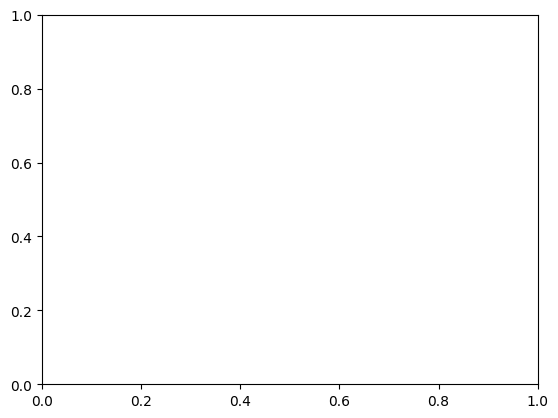

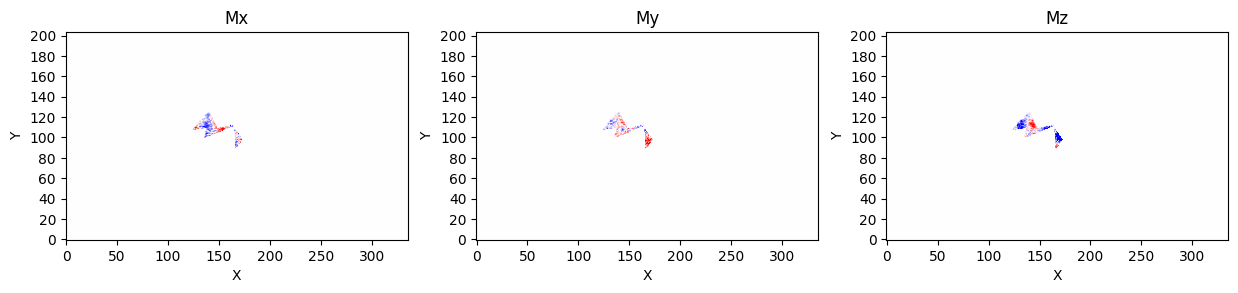

In [120]:
showM()

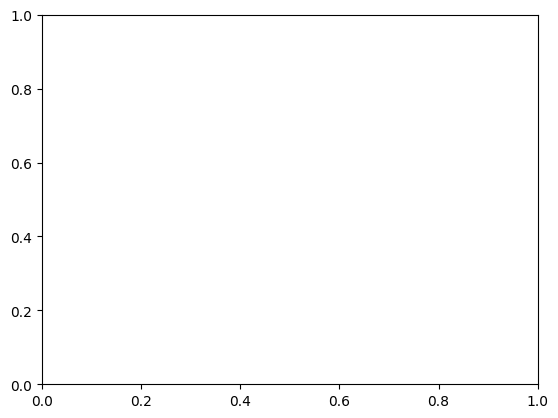

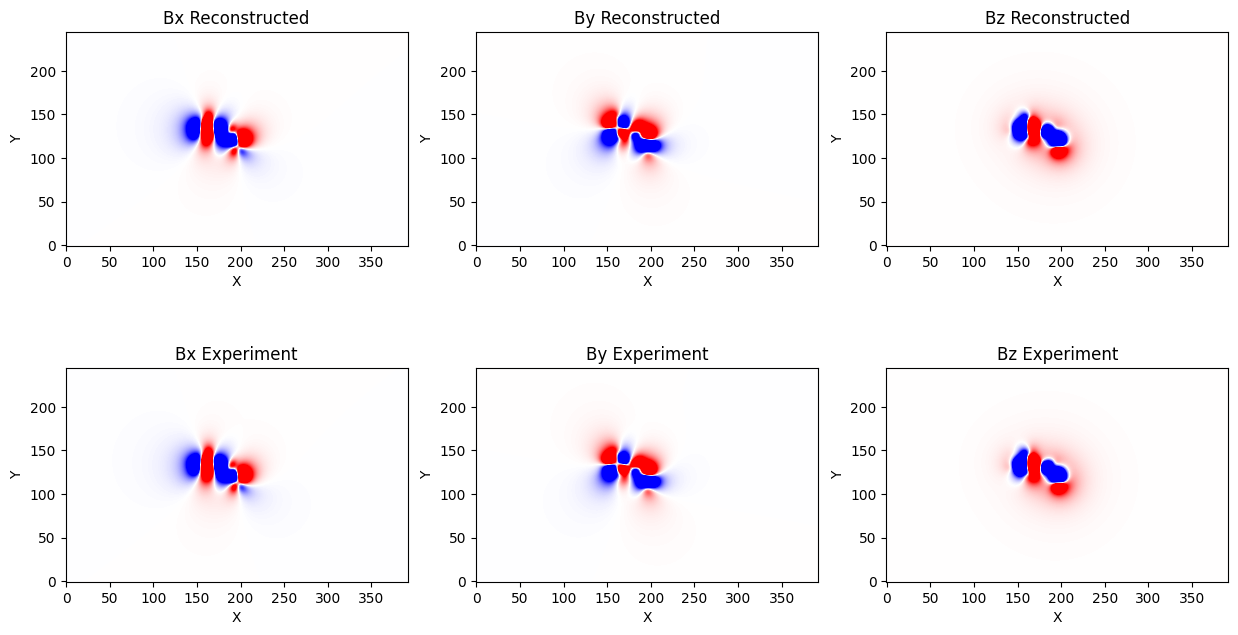

In [121]:
showB()

In [7]:
bPixelX, bPixelY = 392, 245
bExp = cp.zeros(shape=(bPixelX,bPixelY,3),dtype=cp.float64)
bCropped = cp.copy(bExp)
bStartX=0
bStartY=0
bEndX=bPixelX
bEndY=bPixelY
bCropX=bPixelX
bCropY=bPixelY
bRMS=1

In [114]:
for i in range(NofP):
    mRes[i,:] = cp.asarray([2*listX[i]*listY[i]*np.cos(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listY[i]*np.cos(listX[i]/2)*np.sin(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listX[i]*np.sin(listX[i]/4)*np.cos(listY[i]/4)/mPixelX/mPixelY])

In [115]:
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)

In [122]:
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
    mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240703/mRes06.npy',mMat)

In [116]:
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)

In [117]:
mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)

In [118]:
cp.save('20240703/bX06.npy',bExp[:,:,0])
cp.save('20240703/bY06.npy',bExp[:,:,1])
cp.save('20240703/bZ06.npy',bExp[:,:,2])

In [111]:
distance = 6.

In [112]:
matrixAGenerate()

generate coefficient time:	1.573380947113037


In [110]:
mT=np.load('20240703/mTarget.npy')
m12=np.load('20240703/mRes12.npy')
m24=np.load('20240703/mRes24.npy')
m36=np.load('20240703/mRes36.npy')
m48=np.load('20240703/mRes48.npy')
print(np.sum((mT-m12)**2)/np.sum(mT**2))
print(np.sum((mT-m24)**2)/np.sum(mT**2))
print(np.sum((mT-m36)**2)/np.sum(mT**2))
print(np.sum((mT-m48)**2)/np.sum(mT**2))

0.6617111607743023
2.0386367386976962
3.4439037072844267
3.6825694205117365


In [123]:
distance = 18.
matrixAGenerate(False)
for i in range(NofP):
    mRes[i,:] = cp.asarray([2*listX[i]*listY[i]*np.cos(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listY[i]*np.cos(listX[i]/2)*np.sin(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listX[i]*np.sin(listX[i]/4)*np.cos(listY[i]/4)/mPixelX/mPixelY])
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
cp.save('20240703/bX18.npy',bExp[:,:,0])
cp.save('20240703/bY18.npy',bExp[:,:,1])
cp.save('20240703/bZ18.npy',bExp[:,:,2])
for i in range(5000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(1000):
    mRes = step(mRes,alpha=0,beta=0)
for i in range(1000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(2000):
    mRes = step(mRes,alpha=0,beta=0)
print(lossF(mRes))

0.0004619572923195614


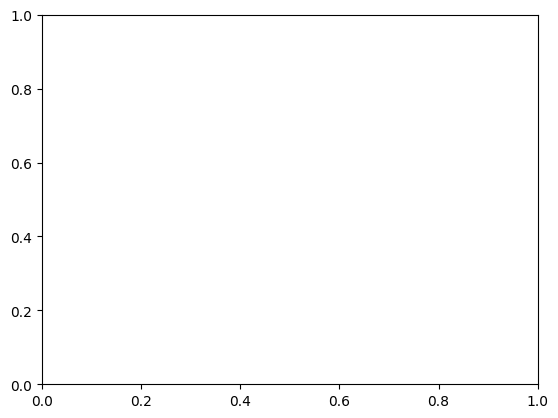

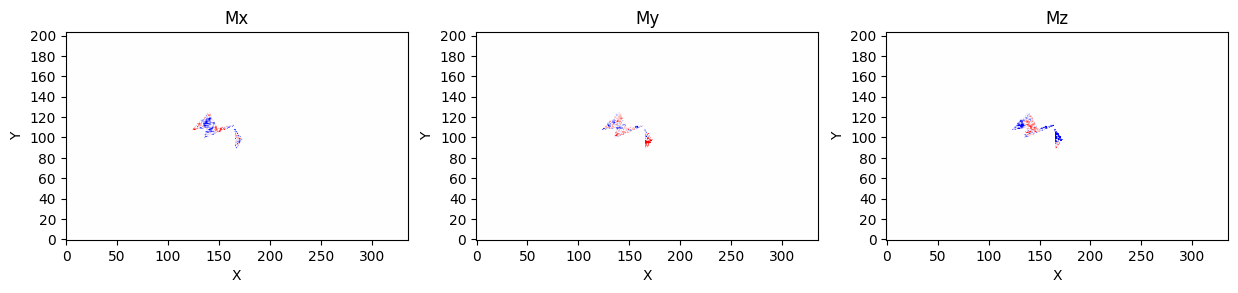

In [124]:
showM()

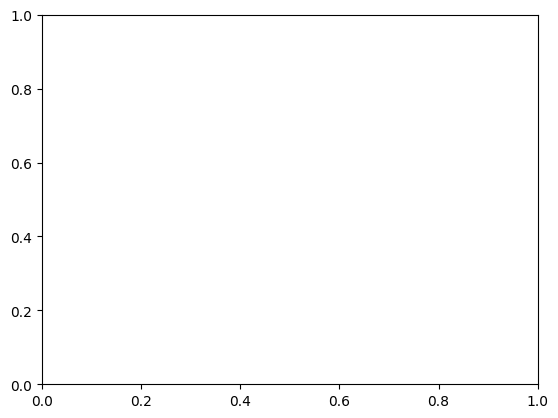

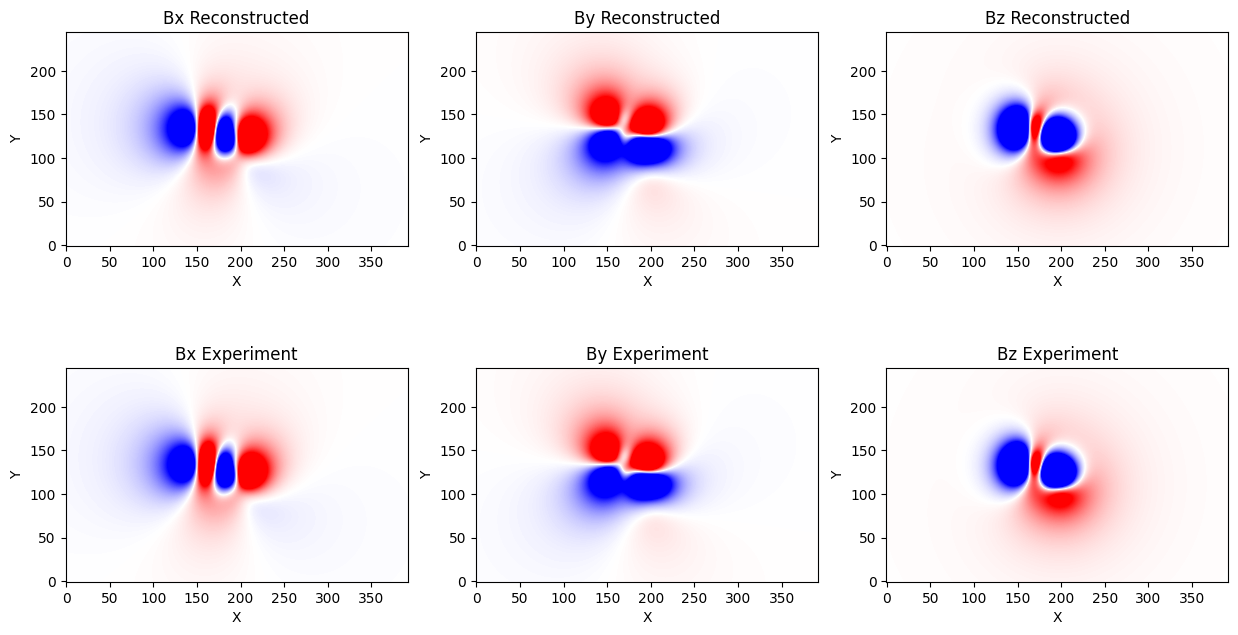

In [125]:
showB()

In [126]:
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
    mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240703/mRes18.npy',mMat)

In [127]:
distance = 9.
matrixAGenerate(False)
for i in range(NofP):
    mRes[i,:] = cp.asarray([2*listX[i]*listY[i]*np.cos(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listY[i]*np.cos(listX[i]/2)*np.sin(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listX[i]*np.sin(listX[i]/4)*np.cos(listY[i]/4)/mPixelX/mPixelY])
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
cp.save('20240703/bX09.npy',bExp[:,:,0])
cp.save('20240703/bY09.npy',bExp[:,:,1])
cp.save('20240703/bZ09.npy',bExp[:,:,2])
for i in range(5000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(1000):
    mRes = step(mRes,alpha=0,beta=0)
for i in range(1000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(2000):
    mRes = step(mRes,alpha=0,beta=0)
print(lossF(mRes))

0.000267021965291156


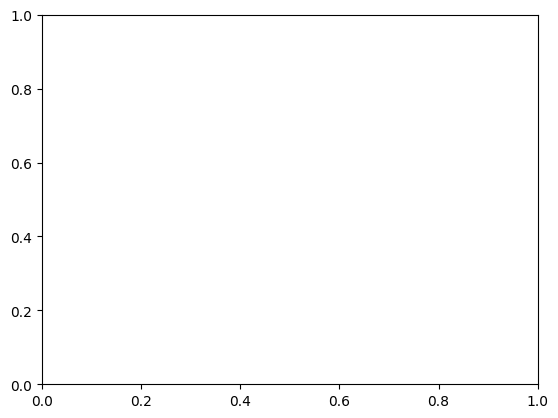

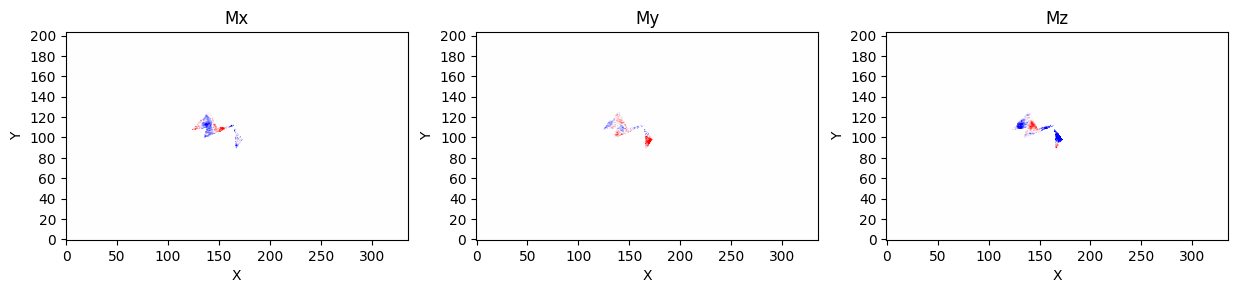

In [128]:
showM()

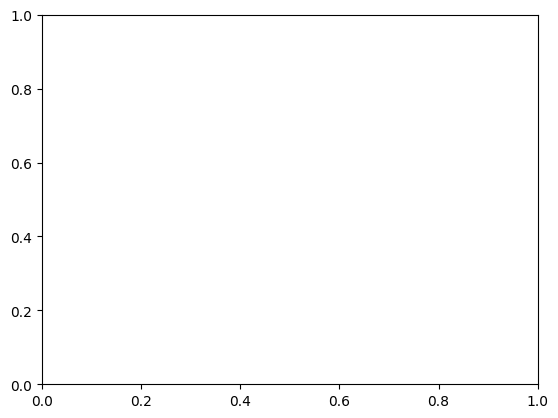

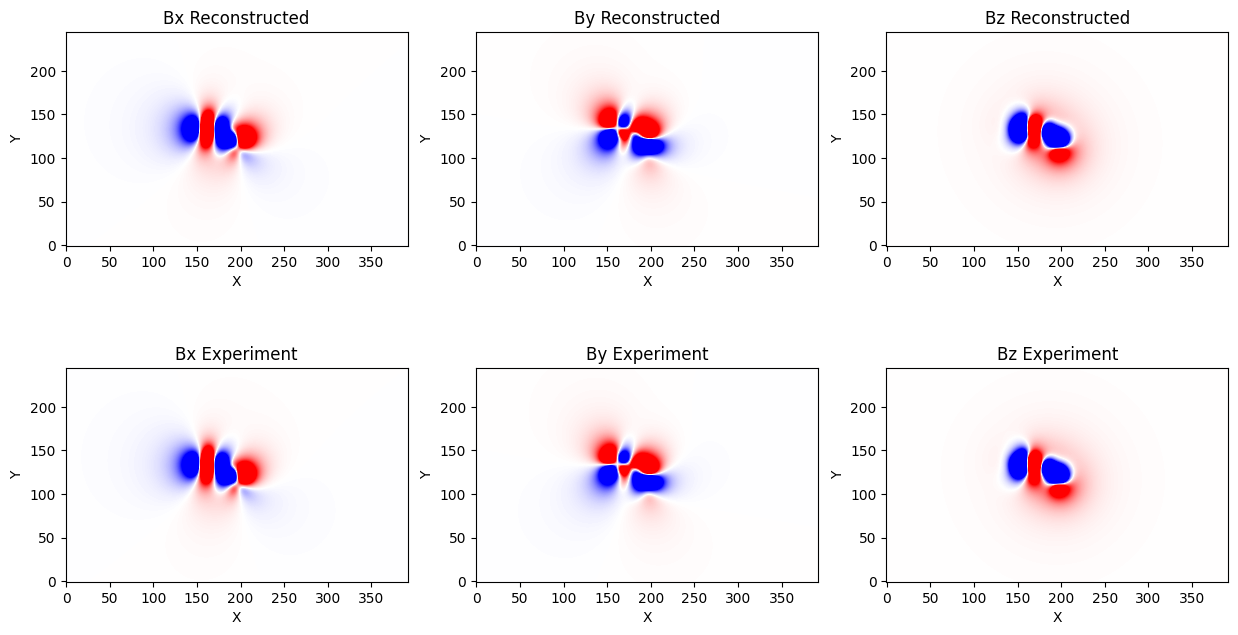

In [129]:
showB()

In [130]:
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
    mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240703/mRes09.npy',mMat)

In [131]:
distance = 4.
matrixAGenerate(False)
for i in range(NofP):
    mRes[i,:] = cp.asarray([2*listX[i]*listY[i]*np.cos(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listY[i]*np.cos(listX[i]/2)*np.sin(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listX[i]*np.sin(listX[i]/4)*np.cos(listY[i]/4)/mPixelX/mPixelY])
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
cp.save('20240703/bX04.npy',bExp[:,:,0])
cp.save('20240703/bY04.npy',bExp[:,:,1])
cp.save('20240703/bZ04.npy',bExp[:,:,2])
for i in range(5000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(1000):
    mRes = step(mRes,alpha=0,beta=0)
for i in range(1000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(2000):
    mRes = step(mRes,alpha=0,beta=0)
print(lossF(mRes))

0.0004981889765989596


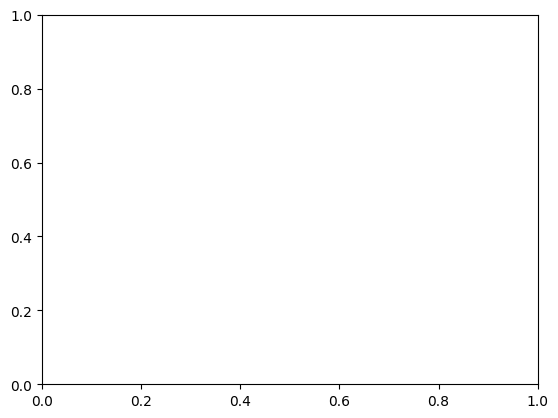

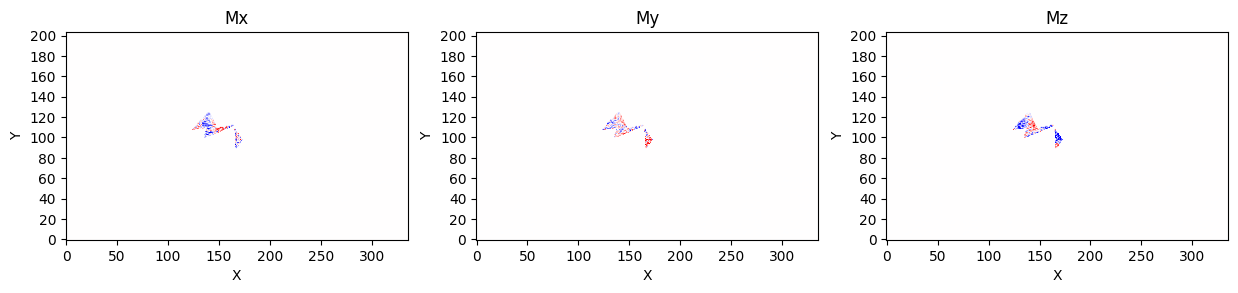

In [132]:
showM()

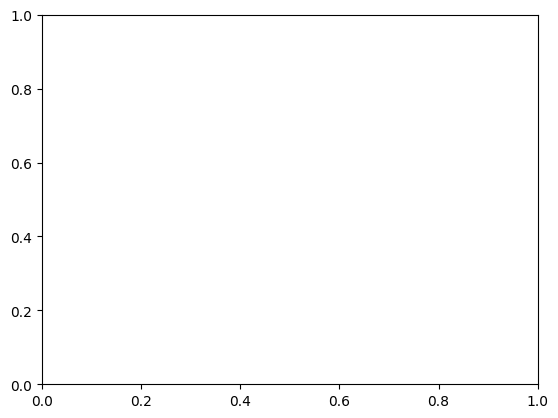

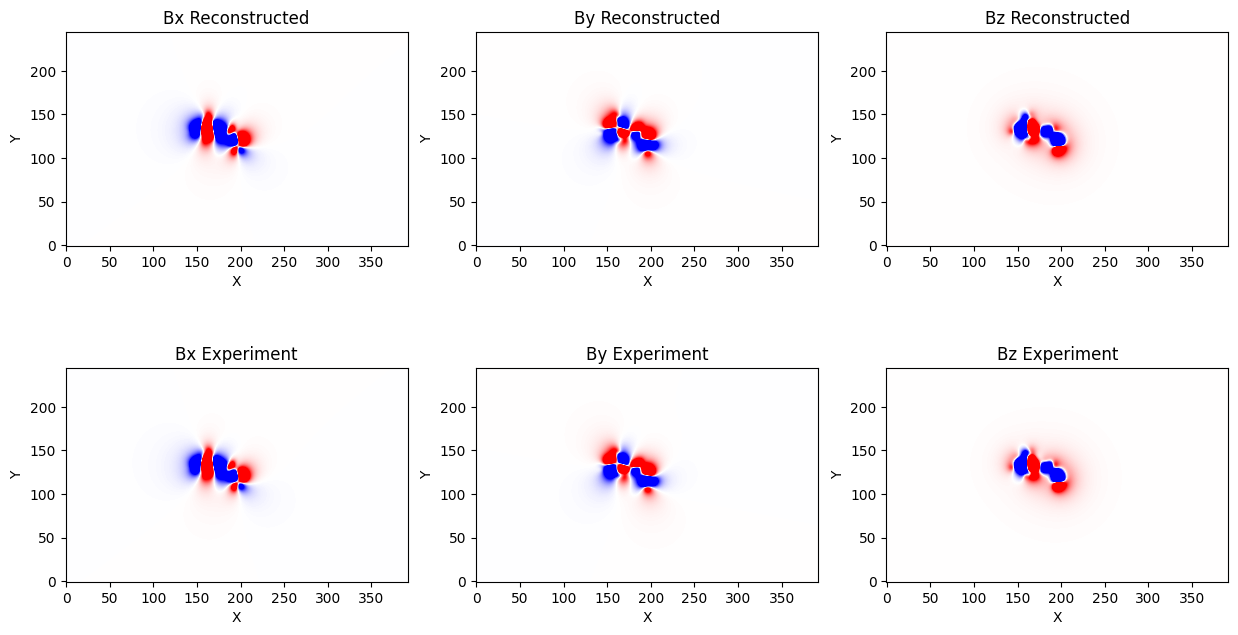

In [133]:
showB()

In [134]:
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
    mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240703/mRes04.npy',mMat)

In [140]:
distance = 6.
matrixAGenerate(False)
for i in range(NofP):
    mRes[i,:] = cp.asarray([2*listX[i]*listY[i]*np.cos(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listY[i]*np.cos(listX[i]/2)*np.sin(listX[i]/4)/mPixelX/mPixelY,
			4*listX[i]*listX[i]*np.sin(listX[i]/4)*np.cos(listY[i]/4)/mPixelX/mPixelY])
bExp = cp.tensordot(matrixA,mRes,axes=([2,4],[0,1]))
bCropped = cp.copy(bExp)
bRMS = np.sqrt(cp.sum(bCropped**2)/bCropX/bCropY/3)
mAVG = bRMS * distance**3 *np.sqrt(bPixelX*bPixelY/mPixelX/mPixelY)
mRes = cp.zeros(shape=(NofP,3),dtype=cp.float64)
cp.save('20240703/bX06.npy',bExp[:,:,0])
cp.save('20240703/bY06.npy',bExp[:,:,1])
cp.save('20240703/bZ06.npy',bExp[:,:,2])
for i in range(5000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(1000):
    mRes = step(mRes,alpha=0,beta=0)
for i in range(1000):
    mRes = step(mRes,alpha=2,beta=2)
for i in range(2000):
    mRes = step(mRes,alpha=0,beta=0)
print(lossF(mRes))

0.0002581351932366789


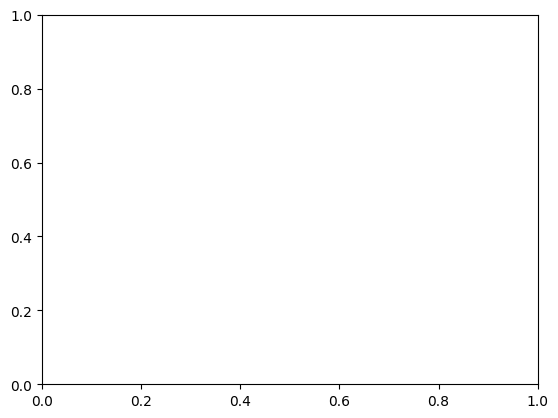

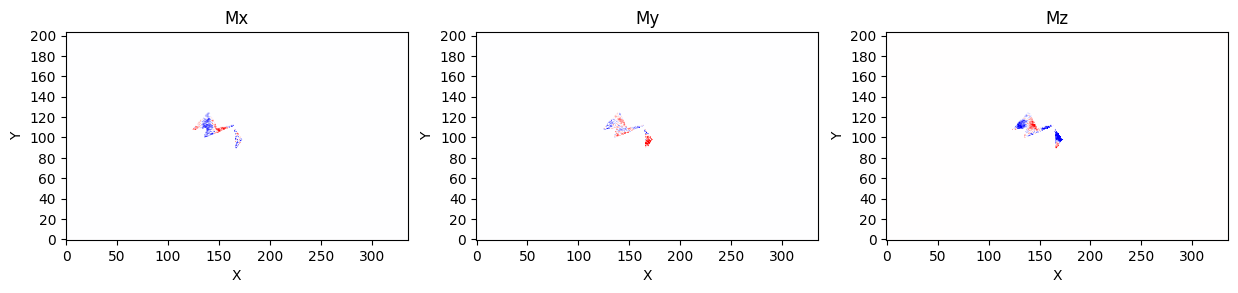

In [141]:
showM()

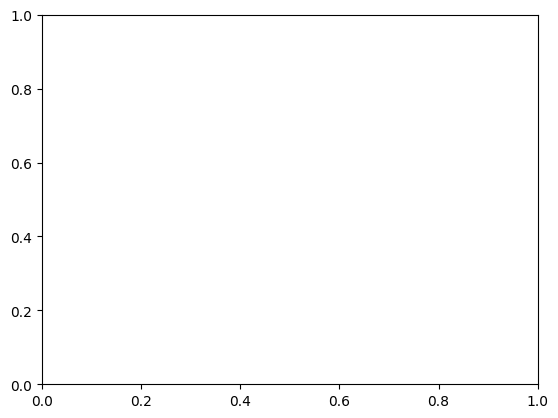

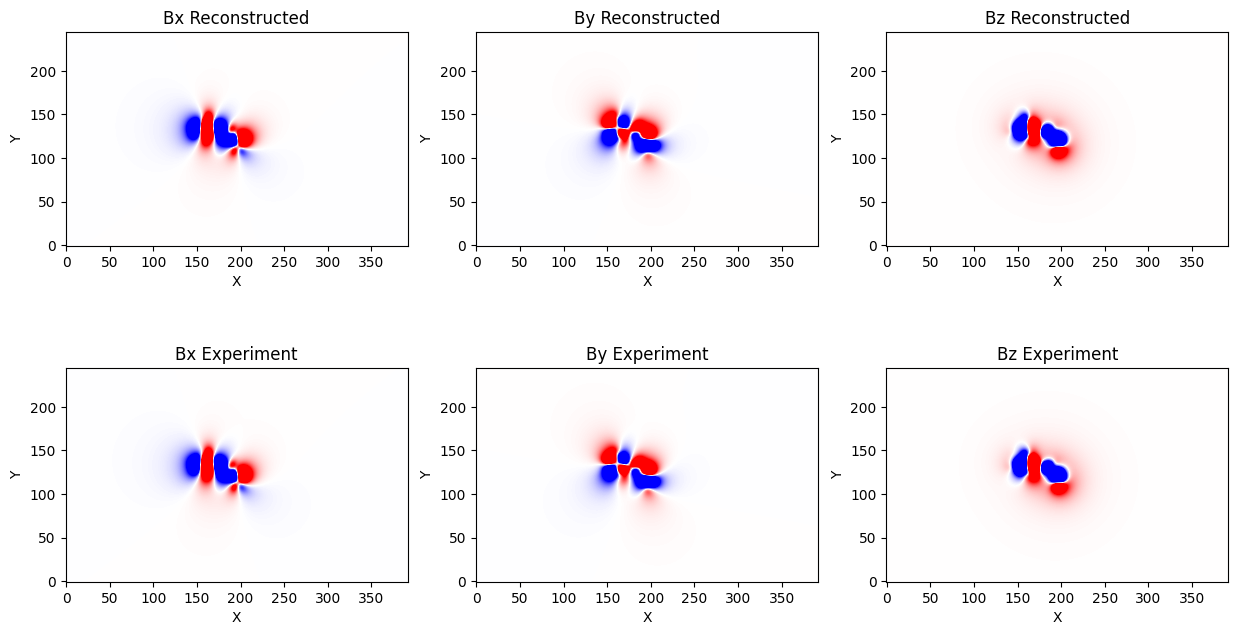

In [142]:
showB()

In [143]:
mMat = cp.zeros(shape=(mPixelX,mPixelY,3),dtype=cp.float64)
for i in range(NofP):
    mMat[listX[i],listY[i],:] = mRes[i,:]
cp.save('20240703/mRes06.npy',mMat)

In [144]:
mT=np.load('20240703/mTarget.npy')
m18=np.load('20240703/mRes18.npy')
m09=np.load('20240703/mRes09.npy')
m04=np.load('20240703/mRes04.npy')
m06=np.load('20240703/mRes06.npy')
print(np.sum((mT-m18)**2)/np.sum(mT**2))
print(np.sum((mT-m09)**2)/np.sum(mT**2))
print(np.sum((mT-m04)**2)/np.sum(mT**2))
print(np.sum((mT-m06)**2)/np.sum(mT**2))

1.1400133142897695
0.5264849704598222
1.3941040096707653
0.5598899851499218


In [145]:
print(np.sum(np.abs(mT-m48))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m36))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m24))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m18))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m12))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m09))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m06))/np.sum(np.abs(mT)))
print(np.sum(np.abs(mT-m04))/np.sum(np.abs(mT)))

1.9829443124550845
1.9632036002694613
1.4672671666874082
1.0901742833658805
0.8004822457569101
0.7115649593951869
0.7523199303002616
1.1973982167497863


In [146]:
def corrP(m,p):
    C=0
    for i in range(NofP):
        if np.sum(((m-mT)[listX[i],listY[i],:])**2) <= 3*p*p*np.sum((mT[listX[i],listY[i],:])**2):
            C+=1
    return C/NofP

In [148]:
mL=[m48,m36,m24,m18,m12,m09,m06,m04]
for i in mL:
    print(corrP(i,0.3),corrP(i,0.5))

0.016666666666666666 0.10714285714285714
0.04047619047619048 0.09761904761904762
0.05 0.17857142857142858
0.09523809523809523 0.31666666666666665
0.18333333333333332 0.5333333333333333
0.2619047619047619 0.6261904761904762
0.25476190476190474 0.5904761904761905
0.09285714285714286 0.30238095238095236
